# Install Packages

In [ ]:
!pip install vaderSentiment
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 663 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=2441d36c4df16a7b8d7ed4d448e9f08e0724e826a2710432a88ff00dfbb4687b
  Stored in directory: /root/.cache/pip/wheels/f6/6f/c3/b305c5107a17618f2938a067d5ffcbb556909d82398762089e
Successfully built afinn


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import regex
import re

afinn = Afinn(language='en')

# Read in Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ows = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ows_tweet_topics.csv')
ows.head()

,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1
0,2,121813150000619521,@Seductivpancake Right! Those guys have a vict...,2011-10-06,2011-10-06 05:04:52,right those guys have victory condition re...,"['right', 'those', 'guys', 'have', 'victory', ...","['right', 'guys', 'victory', 'condition', 'reg...",False,False,6,9
1,4,121813163778899968,#ows White shirt= Brown shirt.,2011-10-06,2011-10-06 05:04:56,#ows white shirt brown shirt,"['#ows', 'white', 'shirt', 'brown', 'shirt']","['white', 'shirt', 'brown', 'shirt']",False,False,4,4
2,13,121813232523558912,@AnonyOps @danielhewitt Wow. Self-defense is ...,2011-10-06,2011-10-06 05:05:12,wow self defense is obviously needed to prot...,"['wow', 'self', 'defense', 'is', 'obviously', ...","['wow', 'self', 'defense', 'obviously', 'neede...",False,False,5,5
3,14,121813245488140288,@HumanityCritic i'm worried that the #ows sell...,2011-10-06,2011-10-06 05:05:15,m worried that the #ows sells out to the ham...,"['m', 'worried', 'that', 'the', '#ows', 'sell'...","['worried', 'sell', 'hamsher', 'norquist', 'sp...",False,False,7,8
4,23,121813284704882688,@LibertyBelle4 LOL! Its sneaking up on a lot o...,2011-10-06,2011-10-06 05:05:24,lol its sneaking up on lot of people but ...,"['lol', 'its', 'sneaking', 'up', 'on', 'lot', ...","['lol', 'sneaking', 'lot', 'sure', 'undivided'...",False,False,4,4


In [ ]:
ows.shape

(1258512, 12)

In [ ]:
ows['Day'] = ows['Day'].astype(str)
ows['date'] = pd.to_datetime(ows['Day'], errors='coerce')

In [ ]:
ows['clean_text'] = ows['clean_text'].astype(str)

# Functions

In [ ]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield.
    Returns scores and original dataframe.'''

    analyzer = SentimentIntensityAnalyzer()

    print('Estimating polarity scores for %d cases.' % len(df))
    sentiment = df[textfield].apply(analyzer.polarity_scores)

    # convert to dataframe
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')

    # merge dataframes
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())

def sentiment_stats(full_vader):
  stats_dict = {}
  stats_dict['PosCount'] = full_vader[full_vader['vader_compound'] > 0.25]['vader_compound'].count()
  print('Count of positive Tweets:' + str(full_vader[full_vader['vader_compound'] > 0.25]['vader_compound'].count()))
  stats_dict['PosPerc'] = full_vader[full_vader['vader_compound'] > 0.25]['vader_compound'].count()/full_vader['vader_compound'].count() * 100
  print('Percent of positive Tweets:' + str(full_vader[full_vader['vader_compound'] > 0.25]['vader_compound'].count()/full_vader['vader_compound'].count() * 100))
  stats_dict['PosAvg'] = full_vader[full_vader['vader_compound'] > 0.25]['vader_compound'].mean()
  print('Average positive Tweet Score:' + str(full_vader[full_vader['vader_compound'] > 0.25]['vader_compound'].mean()))
  print()
  stats_dict['NeuCount'] = full_vader[(full_vader['vader_compound'] <= 0.25) & (full_vader['vader_compound'] >= -0.25)]['vader_compound'].count()
  print('Count of neutral Tweets:' + str(full_vader[(full_vader['vader_compound'] <= 0.25) & (full_vader['vader_compound'] >= -0.25)]['vader_compound'].count()))
  stats_dict['NeuPerc'] = full_vader[(full_vader['vader_compound'] <= 0.25) & (full_vader['vader_compound'] >= -0.25)]['vader_compound'].count()/full_vader['vader_compound'].count() * 100
  print('Percent of neutral Tweets:' + str(full_vader[(full_vader['vader_compound'] <= 0.25) & (full_vader['vader_compound'] >= -0.25)]['vader_compound'].count()/full_vader['vader_compound'].count() * 100))
  stats_dict['NeuAvg'] = full_vader[(full_vader['vader_compound'] <= 0.25) & (full_vader['vader_compound'] >= -0.25)]['vader_compound'].mean()
  print('Average neutral Tweet Score:' + str(full_vader[(full_vader['vader_compound'] <= 0.25) & (full_vader['vader_compound'] >= -0.25)]['vader_compound'].mean()))
  print()
  stats_dict['NegCount'] = full_vader[full_vader['vader_compound'] < -0.25]['vader_compound'].count()
  print('Count of negative Tweets:' + str(full_vader[full_vader['vader_compound'] < -0.25]['vader_compound'].count()))
  stats_dict['NegPerc'] = full_vader[full_vader['vader_compound'] < -0.25]['vader_compound'].count()/full_vader['vader_compound'].count() * 100
  print('Percent of negative Tweets:' + str(full_vader[full_vader['vader_compound'] < -0.25]['vader_compound'].count()/full_vader['vader_compound'].count() * 100))
  stats_dict['NegAvg'] = full_vader[full_vader['vader_compound'] < -0.25]['vader_compound'].mean()
  print('Average negative Tweet Score:' + str(full_vader[full_vader['vader_compound'] < -0.25]['vader_compound'].mean()))
  return stats_dict

def tweets_per_day_calc(ows):
  tweets_per_day = ows.groupby(pd.Grouper(freq="D", key = 'date'))['Twitter ID'].count().reset_index()
  f, ax = plt.subplots()
  ax.plot(tweets_per_day['date'], tweets_per_day['Twitter ID'])
  plt.xticks(rotation=90)
  return tweets_per_day

def tweetLabeler (row):
  if (row['vader_compound'] > 0.25):
    return 1
  elif (row['vader_compound'] < -0.25):
    return -1
  return 0

def commonWordsPerSentiment(full_vader):
  top = Counter([item for sublist in full_vader['lemmatized_tokens'] for item in sublist])
  temp = pd.DataFrame(top.most_common(26))
  temp = temp.iloc[1:,:]
  temp.columns = ['Common_words','count']
  print('Top Words')
  display(temp.style.background_gradient(cmap='Blues'))
  print('-----------------------------------------------------------------')
  pos = full_vader[full_vader['sentiment_label'] == 1]
  top = Counter([item for sublist in pos['lemmatized_tokens'] for item in sublist])
  temp = pd.DataFrame(top.most_common(11))
  temp = temp.iloc[1:,:]
  temp.columns = ['Common_words','count']
  print('Top Positive Words')
  display(temp.style.background_gradient(cmap='Blues'))
  print('-----------------------------------------------------------------')
  neu = full_vader[full_vader['sentiment_label'] == 0]
  top = Counter([item for sublist in neu['lemmatized_tokens'] for item in sublist])
  temp = pd.DataFrame(top.most_common(11))
  temp = temp.iloc[1:,:]
  temp.columns = ['Common_words','count']
  print('Top Neutral Words')
  display(temp.style.background_gradient(cmap='Blues'))
  print('-----------------------------------------------------------------')
  neg = full_vader[full_vader['sentiment_label'] == -1]
  top = Counter([item for sublist in neg['lemmatized_tokens'] for item in sublist])
  temp = pd.DataFrame(top.most_common(11))
  temp = temp.iloc[1:,:]
  temp.columns = ['Common_words','count']
  print('Top Negative Words')
  display(temp.style.background_gradient(cmap='Blues'))
  print('-----------------------------------------------------------------')
  pos_tweets_per_day = pos.groupby(pd.Grouper(freq="D", key = 'date'))['Twitter ID'].count().reset_index()
  f, ax = plt.subplots()
  ax.plot(pos_tweets_per_day['date'], pos_tweets_per_day['Twitter ID'], label = 'Positive Tweets')
  neu_tweets_per_day = neu.groupby(pd.Grouper(freq="D", key = 'date'))['Twitter ID'].count().reset_index()
  ax.plot(neu_tweets_per_day['date'], neu_tweets_per_day['Twitter ID'], label = 'Neutral Tweets')
  neg_tweets_per_day = neg.groupby(pd.Grouper(freq="D", key = 'date'))['Twitter ID'].count().reset_index()
  ax.plot(neg_tweets_per_day['date'], neg_tweets_per_day['Twitter ID'], label = 'Negative Tweets')
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

# Full Corpus Analysis

In [ ]:
full = ows.copy()

In [ ]:
full.shape

(1258512, 13)

In [ ]:
full_vader = vaderize(full, 'clean_text')

Estimating polarity scores for 1258512 cases.


In [ ]:
full_vader['sentiment_label'] = full_vader.apply(lambda row: tweetLabeler(row), axis=1)


In [ ]:
full_vader.head()

,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date,vader_neg,vader_neu,vader_pos,vader_compound,sentiment_label
0,2,121813150000619521,@Seductivpancake Right! Those guys have a vict...,2011-10-06,2011-10-06 05:04:52,right those guys have victory condition re...,"['right', 'those', 'guys', 'have', 'victory', ...","['right', 'guys', 'victory', 'condition', 'reg...",False,False,6,9,2011-10-06,0.000,1.000,0.000,0.0000,0
1,4,121813163778899968,#ows White shirt= Brown shirt.,2011-10-06,2011-10-06 05:04:56,#ows white shirt brown shirt,"['#ows', 'white', 'shirt', 'brown', 'shirt']","['white', 'shirt', 'brown', 'shirt']",False,False,4,4,2011-10-06,0.000,1.000,0.000,0.0000,0
2,13,121813232523558912,@AnonyOps @danielhewitt Wow. Self-defense is ...,2011-10-06,2011-10-06 05:05:12,wow self defense is obviously needed to prot...,"['wow', 'self', 'defense', 'is', 'obviously', ...","['wow', 'self', 'defense', 'obviously', 'neede...",False,False,5,5,2011-10-06,0.142,0.562,0.296,0.6249,1
3,14,121813245488140288,@HumanityCritic i'm worried that the #ows sell...,2011-10-06,2011-10-06 05:05:15,m worried that the #ows sells out to the ham...,"['m', 'worried', 'that', 'the', '#ows', 'sell'...","['worried', 'sell', 'hamsher', 'norquist', 'sp...",False,False,7,8,2011-10-06,0.109,0.891,0.000,-0.2960,-1
4,23,121813284704882688,@LibertyBelle4 LOL! Its sneaking up on a lot o...,2011-10-06,2011-10-06 05:05:24,lol its sneaking up on lot of people but ...,"['lol', 'its', 'sneaking', 'up', 'on', 'lot', ...","['lol', 'sneaking', 'lot', 'sure', 'undivided'...",False,False,4,4,2011-10-06,0.000,0.694,0.306,0.7579,1


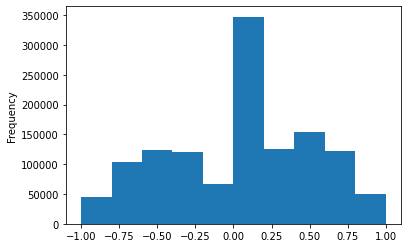

In [ ]:
%matplotlib inline


full_vader['vader_compound'].plot(kind='hist')

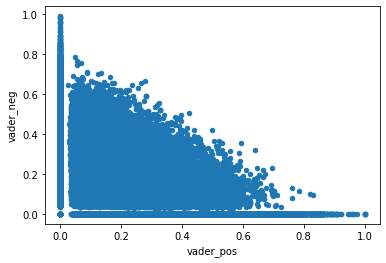

In [ ]:
full_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

full_vader[sentiment_variables].mean()

vader_neg         0.096682
vader_neu         0.791611
vader_pos         0.111682
vader_compound    0.027900
dtype: float64

In [ ]:
full_stats = sentiment_stats(full_vader)

Count of positive Tweets:423970
Percent of positive Tweets:33.68819685469825
Average positive Tweet Score:0.5520712757978158

Count of neutral Tweets:480441
Percent of neutral Tweets:38.17532133185858
Average neutral Tweet Score:-0.002969864770075826

Count of negative Tweets:354101
Percent of negative Tweets:28.136481813443176
Average negative Tweet Score:-0.557813956752452


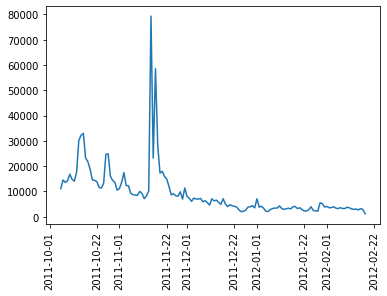

In [ ]:
tweets_per_day = tweets_per_day_calc(full)

In [ ]:
full_key_dates = full[full['date'].isin(key_dates)]
full_key_dates

,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
605664,29819138,136231975299194880,"“@CharlesBivona: If I haven't already said it,...",2011-11-15,2011-11-15 00:00:08,if haven already said it m thoroughly enjoyi...,"['if', 'haven', 'already', 'said', 'it', 'm', ...","['already', 'said', 'thoroughly', 'enjoying', ...",False,False,6,9,2011-11-15
605665,29819140,136231981229944834,I think what has bothered me most about the #t...,2011-11-15,2011-11-15 00:00:10,i think what has bothered me most about the #t...,"['i', 'think', 'what', 'has', 'bothered', 'me'...","['think', 'bothered', '#teaparty', 'rally', 'v...",False,False,4,4,2011-11-15
605666,29819146,136232031972630528,@ANONYMOUSGLOBAL I may not agree with all #ows...,2011-11-15,2011-11-15 00:00:22,may not agree with all #ows ideals but am a...,"['may', 'not', 'agree', 'with', 'all', '#ows',...","['may', 'agree', 'ideal', 'end', 'gov', 'co', ...",False,False,1,9,2011-11-15
605667,29819161,136232109936353280,@amr_abotawila no. Remember Micha who we met t...,2011-11-15,2011-11-15 00:00:40,no remember micha who we met there at the g...,"['no', 'remember', 'micha', 'who', 'we', 'met'...","['remember', 'micha', 'met', 'greek', 'embassy...",False,False,7,8,2011-11-15
605668,29819170,136232163581509632,Occupy Wall Street #OWS,2011-11-15,2011-11-15 00:00:53,occupy wall street #ows,"['occupy', 'wall', 'street', '#ows']","['occupy', 'wall', 'street', '']",False,False,4,4,2011-11-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
794984,41982586,137681403759443968,#ScottOlsen benefit show @924Gilman TONIGHT Ni...,2011-11-18,2011-11-18 23:59:39,#scottolsen benefit show tonight nihilist cunt...,"['#scottolsen', 'benefit', 'show', 'tonight', ...","['#scottolsen', 'benefit', 'show', 'tonight', ...",False,False,7,8,2011-11-18
794985,41982593,137681423107756033,When the freedoms of those you dislike are att...,2011-11-18,2011-11-18 23:59:43,when the freedoms of those you dislike are att...,"['when', 'the', 'freedom', 'of', 'those', 'you...","['freedom', 'dis', 'attacked', 'freedom', 'dis...",False,False,4,4,2011-11-18
794986,41982597,137681436256911360,i will no longer be just a pawn in their game ...,2011-11-18,2011-11-18 23:59:47,i will no longer be just pawn in their game #ows,"['i', 'will', 'no', 'longer', 'be', 'just', 'p...","['longer', 'pawn', 'game', '']",False,False,6,9,2011-11-18
794987,41982600,137681447086600192,MT @OccupyVancouver: injunction granted 2 rem...,2011-11-18,2011-11-18 23:59:49,injunction granted remove #occupyvancouver by...,"['injunction', 'granted', 'remove', '#occupyva...","['injunction', 'granted', 'remove', 'vancouver...",False,False,7,8,2011-11-18


In [ ]:
temp1 = full_key_dates['Topic'].value_counts().reset_index().rename(columns={"Topic": "NumValues", "index": "Topic"})
temp1['percent'] = (temp1['NumValues'] / temp1['NumValues'].sum()) * 100
temp1

,Topic,NumValues,percent
0,5,55298,29.233453
1,4,31846,16.835483
2,3,28618,15.128991
3,7,28132,14.872066
4,6,27124,14.339184
5,1,8665,4.580778
6,0,6030,3.187778
7,2,3447,1.822267


In [ ]:
temp2 = full['Topic'].value_counts().reset_index().rename(columns={"Topic": "NumValues", "index": "Topic"})
temp2['percent'] = (temp2['NumValues'] / temp2['NumValues'].sum()) * 100
temp2

,Topic,NumValues,percent
0,4,266432,21.170398
1,6,222949,17.715286
2,7,194445,15.450389
3,3,187537,14.901487
4,5,177784,14.126524
5,1,116058,9.221843
6,0,54152,4.302859
7,2,39155,3.111214


In [ ]:
key_dates = [pd.Timestamp(year=2011, month=11, day=15), pd.Timestamp(year=2011, month=11, day=16), pd.Timestamp(year=2011, month=11, day=17), pd.Timestamp(year=2011, month=11, day=18)]

[Timestamp('2011-11-15 00:00:00'),
 Timestamp('2011-11-16 00:00:00'),
 Timestamp('2011-11-17 00:00:00'),
 Timestamp('2011-11-18 00:00:00')]

In [ ]:
tweets_per_day.sort_values(by = 'Twitter ID', ascending = False).head(20)

,date,Twitter ID
40,2011-11-15,79305
42,2011-11-17,58478
10,2011-10-16,32958
9,2011-10-15,32182
8,2011-10-14,30217
43,2011-11-18,28213
21,2011-10-27,24832
20,2011-10-26,24618
11,2011-10-17,23211
41,2011-11-16,23164


Top Words


,Common_words,count
1,police,47233
2,right,45963
3,oakland,39729
4,#teaparty,39291
5,us,39112
6,need,38073
7,street,37369
8,movement,36159
9,time,35780
10,occupy,35056


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,support,20898
2,us,16031
3,good,15427
4,right,15045
5,movement,14296
6,need,14092
7,love,13751
8,party,13191
9,want,12720
10,would,12630


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,right,16207
2,street,16106
3,oakland,15951
4,police,15837
5,occupy,14983
6,park,14659
7,need,14386
8,#teaparty,13678
9,time,13582
10,want,13159


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,police,21275
2,right,14711
3,protester,14302
4,#teaparty,13029
5,protest,12610
6,oakland,11367
7,#ronpaul,11315
8,one,10956
9,us,10657
10,stop,10434


-----------------------------------------------------------------


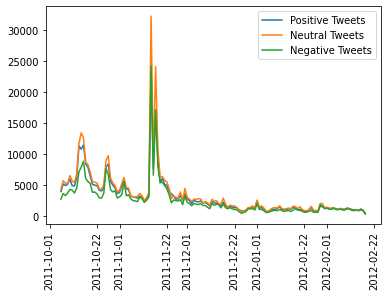

In [ ]:
commonWordsPerSentiment(full_vader)

# Topic 0

In [ ]:
t0_vader = full_vader[full_vader['Topic']== 0]

In [ ]:
topic0 = ows[ows['Topic']==0].reset_index()
topic0.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,7,31,121813318427099136,#Hannity in 2009 on #TeaParty : Their outrage ...,2011-10-06,2011-10-06 05:05:32,#hannity in on #teaparty their outrage at corp...,"['#hannity', 'in', 'on', '#teaparty', 'their',...","['#hannity', '#teaparty', 'outrage', 'corporat...",False,False,0,0,2011-10-06
1,78,375,121814800203395072,"I remember Celente,Beck,Jones, Howse, everybod...",2011-10-06,2011-10-06 05:11:26,i remember celente beck jones howse everybod...,"['i', 'remember', 'celente', 'beck', 'jones', ...","['remember', 'celente', 'beck', 'jones', 'hows...",False,False,0,0,2011-10-06
2,169,788,121816659429294080,#OWS,2011-10-06,2011-10-06 05:18:49,#ows,['#ows'],[''],False,False,0,0,2011-10-06
3,174,818,121816762110058496,@Genespark #ows &quot;Our repeated Petitions h...,2011-10-06,2011-10-06 05:19:13,#ows our repeated petitions have been answer...,"['#ows', 'our', 'repeated', 'petition', 'have'...","['repeated', 'petition', 'answered', 'repeated...",False,False,0,0,2011-10-06
4,201,975,121817566283968513,@evanbanks @explainify no! #OWS,2011-10-06,2011-10-06 05:22:25,no #ows,"['no', '#ows']",[''],False,False,0,0,2011-10-06


In [ ]:
topic0.shape

(54152, 13)

In [ ]:
t0_vader = vaderize(topic0, 'clean_text')

Estimating polarity scores for 54152 cases.


In [ ]:
t0_vader.head()

,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date,vader_neg,vader_neu,vader_pos,vader_compound,sentiment_label
7,31,121813318427099136,#Hannity in 2009 on #TeaParty : Their outrage ...,2011-10-06,2011-10-06 05:05:32,#hannity in on #teaparty their outrage at corp...,"['#hannity', 'in', 'on', '#teaparty', 'their',...","[#hannity, #teaparty, outrage, corporate, ...",False,False,0,0,2011-10-06,0.281,0.369,0.349,0.5267,1
78,375,121814800203395072,"I remember Celente,Beck,Jones, Howse, everybod...",2011-10-06,2011-10-06 05:11:26,i remember celente beck jones howse everybod...,"['i', 'remember', 'celente', 'beck', 'jones', ...","[remember, celente, beck, jones, howse, e...",False,False,0,0,2011-10-06,0.082,0.918,0.000,-0.2846,-1
169,788,121816659429294080,#OWS,2011-10-06,2011-10-06 05:18:49,#ows,['#ows'],[],False,False,0,0,2011-10-06,0.000,1.000,0.000,0.0000,0
174,818,121816762110058496,@Genespark #ows &quot;Our repeated Petitions h...,2011-10-06,2011-10-06 05:19:13,#ows our repeated petitions have been answer...,"['#ows', 'our', 'repeated', 'petition', 'have'...","[repeated, petition, answered, repeated, i...",False,False,0,0,2011-10-06,0.219,0.781,0.000,-0.4215,-1
201,975,121817566283968513,@evanbanks @explainify no! #OWS,2011-10-06,2011-10-06 05:22:25,no #ows,"['no', '#ows']",[],False,False,0,0,2011-10-06,0.688,0.312,0.000,-0.2960,-1


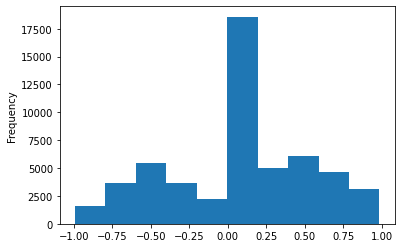

In [ ]:
%matplotlib inline


t0_vader['vader_compound'].plot(kind='hist')

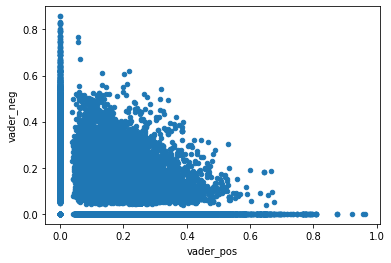

In [ ]:
t0_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t0_vader[sentiment_variables].mean()

vader_neg         0.087591
vader_neu         0.801668
vader_pos         0.110188
vader_compound    0.052439
dtype: float64

In [ ]:
t0_stats = sentiment_stats(t0_vader)

Count of positive Tweets:17752
Percent of positive Tweets:32.7817993795243
Average positive Tweet Score:0.5760305655700767

Count of neutral Tweets:22962
Percent of neutral Tweets:42.40286600679568
Average neutral Tweet Score:0.0040766832157477575

Count of negative Tweets:13438
Percent of negative Tweets:24.81533461368001
Average negative Tweet Score:-0.5566011534454531


,date,Twitter ID
0,2011-10-06,420
1,2011-10-07,579
2,2011-10-08,452
3,2011-10-09,410
4,2011-10-10,522
...,...,...
131,2012-02-14,441
132,2012-02-15,352
133,2012-02-16,421
134,2012-02-17,409


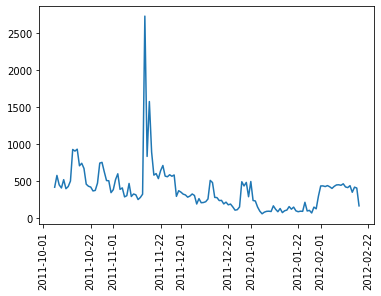

In [ ]:
tweets_per_day_calc(topic0)

Top Words


,Common_words,count
1,#ronpaul,12744
2,#teaparty,7715
3,government,4586
4,,4242
5,#anonymous,4076
6,free,3679
7,liberty,3047
8,right,2924
9,us,2849
10,freedom,2819


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,#ronpaul,5621
2,#teaparty,3173
3,free,2480
4,liberty,2306
5,freedom,2212
6,government,1773
7,#anonymous,1569
8,speech,1510
9,right,1317
10,us,1022


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,,3592
2,#ronpaul,3394
3,#teaparty,2115
4,government,1449
5,#anonymous,1150
6,right,961
7,us,934
8,#ndaa,758
9,money,751
10,free,711


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,#ronpaul,3729
2,#teaparty,2427
3,government,1364
4,#anonymous,1357
5,us,893
6,money,770
7,one,749
8,debt,743
9,threat,698
10,right,646


-----------------------------------------------------------------


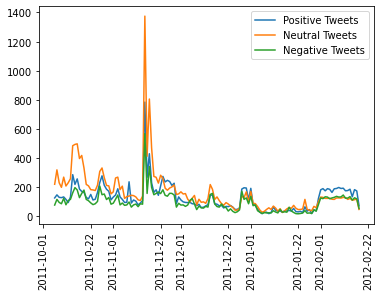

In [ ]:
commonWordsPerSentiment(t0_vader)

# Topic 1

In [ ]:
t1_vader = full_vader[full_vader['Topic']== 1]

In [ ]:
topic1 = ows[ows['Topic']==1].reset_index()
topic1.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,16,78,121813654873182208,GOP says corps./rich can't afford to lose govt...,2011-10-06,2011-10-06 05:06:53,gop says corps rich can afford to lose govt as...,"['gop', 'says', 'corp', 'rich', 'can', 'afford...","['gop', 'says', 'corp', 'rich', 'afford', 'los...",False,False,1,9,2011-10-06
1,48,226,121814238875496448,'We the People' didn't vote to empanel a &quot...,2011-10-06,2011-10-06 05:09:12,we the people didn vote to empanel super com...,"['we', 'the', 'people', 'didn', 'vote', 'to', ...","['vote', 'empanel', 'super', 'committee', '']",False,False,1,9,2011-10-06
2,70,323,121814601259155457,The problem with representational democracy is...,2011-10-06,2011-10-06 05:10:38,the problem with representational democracy is...,"['the', 'problem', 'with', 'representational',...","['problem', 'representational', 'democracy', '...",False,False,1,9,2011-10-06
3,76,359,121814744108765184,@GilesMcK @mydixie_wrecked @keder we can aid t...,2011-10-06,2011-10-06 05:11:12,we can aid the cause by sending billy the ext...,"['we', 'can', 'aid', 'the', 'cause', 'by', 'se...","['aid', 'cause', 'sending', 'billy', 'extermin...",False,False,1,9,2011-10-06
4,87,391,121814871607214080,@greg_rakozy and regardless #OWS doesn't argue...,2011-10-06,2011-10-06 05:11:43,and regardless #ows doesn argue that they sh...,"['and', 'regardless', '#ows', 'doesn', 'argue'...","['regardless', 'argue', 'money', 'made', 'argu...",False,False,1,9,2011-10-06


In [ ]:
topic1.shape

(116058, 13)

In [ ]:
t1_vader = vaderize(topic1, 'clean_text')

Estimating polarity scores for 116058 cases.


In [ ]:
t1_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,16,16,78,78,121813654873182208,GOP says corps./rich can't afford to lose govt...,gop says corps rich can afford to lose govt as...,"['gop', 'says', 'corp', 'rich', 'can', 'afford...","['gop', 'says', 'corp', 'rich', 'afford', 'los...",False,False,1,9,0.256,0.607,0.137,-0.5499
1,48,48,226,226,121814238875496448,'We the People' didn't vote to empanel a &quot...,we the people didn vote to empanel super com...,"['we', 'the', 'people', 'didn', 'vote', 'to', ...","['vote', 'empanel', 'super', 'committee', '']",False,False,1,9,0.000,0.698,0.302,0.5994
2,70,70,323,323,121814601259155457,The problem with representational democracy is...,the problem with representational democracy is...,"['the', 'problem', 'with', 'representational',...","['problem', 'representational', 'democracy', '...",False,False,1,9,0.172,0.828,0.000,-0.4019
3,76,76,359,359,121814744108765184,@GilesMcK @mydixie_wrecked @keder we can aid t...,we can aid the cause by sending billy the ext...,"['we', 'can', 'aid', 'the', 'cause', 'by', 'se...","['aid', 'cause', 'sending', 'billy', 'extermin...",False,False,1,9,0.000,1.000,0.000,0.0000
4,87,87,391,391,121814871607214080,@greg_rakozy and regardless #OWS doesn't argue...,and regardless #ows doesn argue that they sh...,"['and', 'regardless', '#ows', 'doesn', 'argue'...","['regardless', 'argue', 'money', 'made', 'argu...",False,False,1,9,0.274,0.726,0.000,-0.7003


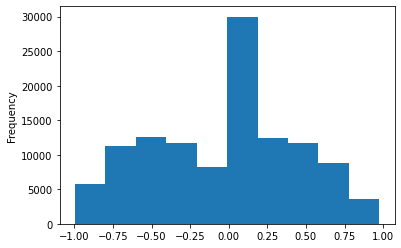

In [ ]:
%matplotlib inline


t1_vader['vader_compound'].plot(kind='hist')

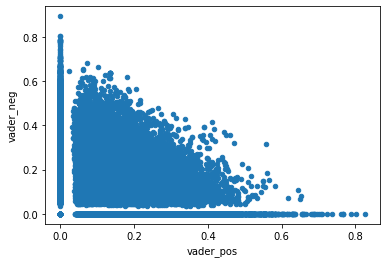

In [ ]:
t1_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t1_vader[sentiment_variables].mean()

vader_neg         0.111872
vader_neu         0.791991
vader_pos         0.096137
vader_compound   -0.044981
dtype: float64

In [ ]:
t1_stats = sentiment_stats(t1_vader)

Count of positive Tweets:32811
Percent of positive Tweets:28.27120922297472
Average positive Tweet Score:0.5293843223309255

Count of neutral Tweets:44059
Percent of neutral Tweets:37.96291509417705
Average neutral Tweet Score:0.001816990853174153

Count of negative Tweets:39188
Percent of negative Tweets:33.765875682848225
Average negative Tweet Score:-0.5784948810860469


,date,Twitter ID
0,2011-10-06,935
1,2011-10-07,1293
2,2011-10-08,1185
3,2011-10-09,1338
4,2011-10-10,1452
...,...,...
131,2012-02-14,711
132,2012-02-15,540
133,2012-02-16,680
134,2012-02-17,659


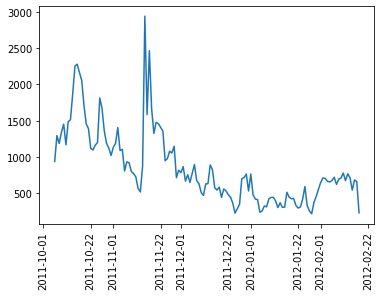

In [ ]:
tweets_per_day_calc(topic1)

In [ ]:
commonWordsPerSentiment(t1_vader)

Top Words


,Common_words,count
1,#ronpaul,12178
2,tax,12006
3,#teaparty,6882
4,usa,6211
5,american,6013
6,state,5742
7,money,5588
8,bank,5275
9,pay,5231
10,war,4783


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,tax,3598
2,#ronpaul,2854
3,state,2390
4,interest,1842
5,#teaparty,1832
6,jobs,1706
7,american,1547
8,usa,1528
9,wealth,1484
10,rich,1482


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,tax,4612
2,#ronpaul,4458
3,#teaparty,2629
4,money,2558
5,usa,2361
6,american,2033
7,state,1996
8,bank,1984
9,pay,1942
10,congress,1911


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,#ronpaul,4866
2,war,4209
3,tax,3796
4,american,2433
5,#teaparty,2421
6,usa,2322
7,class,2190
8,pay,2042
9,bank,2022
10,government,1817


# Topic 2

In [ ]:
t2_vader = full_vader[full_vader['Topic']== 2]

In [ ]:
topic2 = ows[ows['Topic']==2].reset_index()
topic2.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,83,382,121814822357700610,@claudialouback @LIFESOFTWARE @kake07 @ChirpyB...,2011-10-06,2011-10-06 05:11:31,#ff #ows #idwp,"['#ff', '#ows', '#idwp']","['#ff', '#idwp']",False,False,2,2,2011-10-06
1,180,839,121817003953635328,TopTag(3hrs) 1:#quote 2:#OccupyWallStreet 3:#P...,2011-10-06,2011-10-06 05:20:11,toptag 3hrs #quote #occupywallstreet #pop #elc...,"['toptag', '3hrs', '#quote', '#occupywallstree...","['toptag', '3hrs', '#quote', '#pop', '#elcomie...",False,False,2,2,2011-10-06
2,480,2486,121822900889206784,"much like the #OWS loons, the Westboro Baptist...",2011-10-06,2011-10-06 05:43:37,much like the #ows loons the westboro baptist...,"['much', 'like', 'the', '#ows', 'loon', 'the',...","['much', 'loon', 'westboro', 'baptist', 'churc...",False,False,2,2,2011-10-06
3,504,2620,121823490339905536,#OccupyPuertoRico #ows #occupywallstreet,2011-10-06,2011-10-06 05:45:58,#occupypuertorico #ows #occupywallstreet,"['#occupypuertorico', '#ows', '#occupywallstre...","['puertorico', '']",False,False,2,2,2011-10-06
4,708,3739,121827786544525312,"For idiocy of the month prz, @anonlgrisback th...",2011-10-06,2011-10-06 06:03:02,for idiocy of the month prz thinks jewish high...,"['for', 'idiocy', 'of', 'the', 'month', 'prz',...","['idiocy', 'month', 'prz', 'think', 'jewish', ...",False,False,2,2,2011-10-06


In [ ]:
topic2.shape

(39155, 13)

In [ ]:
t2_vader = vaderize(topic2, 'clean_text')

Estimating polarity scores for 39155 cases.


In [ ]:
t2_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,83,83,382,382,121814822357700610,@claudialouback @LIFESOFTWARE @kake07 @ChirpyB...,#ff #ows #idwp,"['#ff', '#ows', '#idwp']","['#ff', '#idwp']",False,False,2,2,0.000,1.000,0.000,0.0000
1,180,180,839,839,121817003953635328,TopTag(3hrs) 1:#quote 2:#OccupyWallStreet 3:#P...,toptag 3hrs #quote #occupywallstreet #pop #elc...,"['toptag', '3hrs', '#quote', '#occupywallstree...","['toptag', '3hrs', '#quote', '#pop', '#elcomie...",False,False,2,2,0.000,1.000,0.000,0.0000
2,480,480,2486,2486,121822900889206784,"much like the #OWS loons, the Westboro Baptist...",much like the #ows loons the westboro baptist...,"['much', 'like', 'the', '#ows', 'loon', 'the',...","['much', 'loon', 'westboro', 'baptist', 'churc...",False,False,2,2,0.093,0.784,0.123,0.1531
3,504,504,2620,2620,121823490339905536,#OccupyPuertoRico #ows #occupywallstreet,#occupypuertorico #ows #occupywallstreet,"['#occupypuertorico', '#ows', '#occupywallstre...","['puertorico', '']",False,False,2,2,0.000,1.000,0.000,0.0000
4,708,708,3739,3739,121827786544525312,"For idiocy of the month prz, @anonlgrisback th...",for idiocy of the month prz thinks jewish high...,"['for', 'idiocy', 'of', 'the', 'month', 'prz',...","['idiocy', 'month', 'prz', 'think', 'jewish', ...",False,False,2,2,0.000,0.856,0.144,0.4019


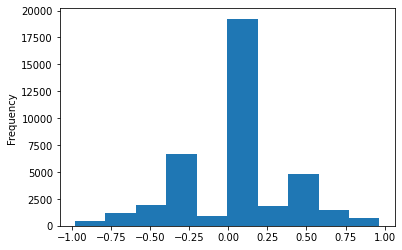

In [ ]:
%matplotlib inline


t2_vader['vader_compound'].plot(kind='hist')

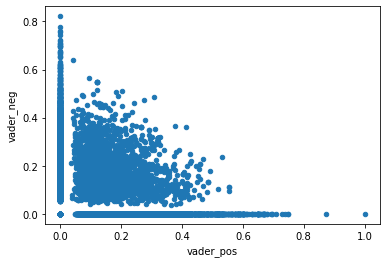

In [ ]:
t2_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t2_vader[sentiment_variables].mean()

vader_neg         0.063436
vader_neu         0.869103
vader_pos         0.067488
vader_compound    0.011366
dtype: float64

In [ ]:
t2_stats = sentiment_stats(t2_vader)

Count of positive Tweets:8352
Percent of positive Tweets:21.3306091176095
Average positive Tweet Score:0.5059336566091954

Count of neutral Tweets:21031
Percent of neutral Tweets:53.71216958242881
Average neutral Tweet Score:0.007266392468261138

Count of negative Tweets:9772
Percent of negative Tweets:24.95722129996169
Average negative Tweet Score:-0.40251124641833813


,date,Twitter ID
0,2011-10-06,193
1,2011-10-07,281
2,2011-10-08,240
3,2011-10-09,289
4,2011-10-10,377
...,...,...
131,2012-02-14,160
132,2012-02-15,140
133,2012-02-16,162
134,2012-02-17,162


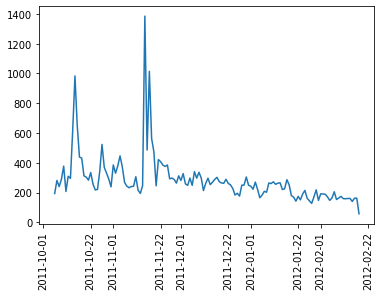

In [ ]:
tweets_per_day_calc(topic2)

Top Words


,Common_words,count
1,temp,11655
2,nyc,10205
3,forecast,9877
4,high,6192
5,#teaparty,5735
6,low,5678
7,#tlot,5010
8,night,5002
9,de,4779
10,rain,4190


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,high,2465
2,sunny,2421
3,temp,2414
4,nyc,2110
5,forecast,2030
6,#teaparty,1569
7,#tlot,1228
8,58f,884
9,#topprog,860
10,#gop,853


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,temp,4919
2,nyc,4460
3,forecast,4265
4,high,3611
5,de,3412
6,#teaparty,2508
7,rain,2300
8,#tlot,2192
9,la,2034
10,#sgp,1708


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,low,4290
2,nyc,3635
3,night,3584
4,forecast,3582
5,,3030
6,rain,1865
7,#teaparty,1658
8,#tlot,1590
9,#sgp,1296
10,#topprog,1289


-----------------------------------------------------------------


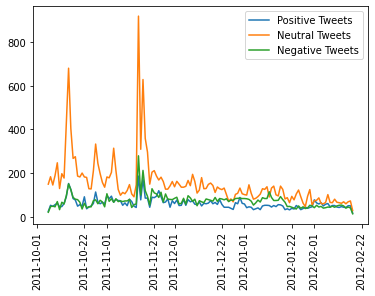

In [ ]:
commonWordsPerSentiment(t2_vader)

# Topic 3

In [ ]:
t3_vader = full_vader[full_vader['Topic']== 3]

In [ ]:
topic3 = ows[ows['Topic']==3].reset_index()
topic3.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,5,27,121813304619446272,"There is no date on the letter, nor author. It...",2011-10-06,2011-10-06 05:05:29,there is no date on the letter nor author it...,"['there', 'is', 'no', 'date', 'on', 'the', 'le...","['date', 'letter', 'author', 'official', 'call...",False,False,3,8,2011-10-06
1,19,91,121813697025945601,@occupy_slc Our group is coming tomorrow from ...,2011-10-06,2011-10-06 05:07:03,our group is coming tomorrow from ut county ...,"['our', 'group', 'is', 'coming', 'tomorrow', '...","['group', 'coming', 'tomorrow', 'ut', 'county'...",False,False,3,8,2011-10-06
2,22,97,121813746237706240,How will the mainstream media handle this? Tun...,2011-10-06,2011-10-06 05:07:14,how will the mainstream media handle this tun...,"['how', 'will', 'the', 'mainstream', 'medium',...","['mainstream', 'medium', 'handle', 'tune', '#t...",False,False,3,8,2011-10-06
3,26,110,121813773190311936,@resabena way to hit every trend at 1ce. + #OW...,2011-10-06,2011-10-06 05:07:21,way to hit every trend at 1ce #ows has negat...,"['way', 'to', 'hit', 'every', 'trend', 'at', '...","['way', 'hit', 'every', 'trend', '1ce', 'negat...",False,False,3,8,2011-10-06
4,28,118,121813813073936384,@laurapcd1 it seems #ows dropped in interest a...,2011-10-06,2011-10-06 05:07:30,it seems #ows dropped in interest after shif...,"['it', 'seems', '#ows', 'dropped', 'in', 'inte...","['seems', 'dropped', 'interest', 'shift', 'cha...",False,False,3,8,2011-10-06


In [ ]:
topic3.shape

(187537, 13)

In [ ]:
t3_vader = vaderize(topic3, 'clean_text')

Estimating polarity scores for 187537 cases.


In [ ]:
t3_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,5,5,27,27,121813304619446272,"There is no date on the letter, nor author. It...",there is no date on the letter nor author it...,"['there', 'is', 'no', 'date', 'on', 'the', 'le...","['date', 'letter', 'author', 'official', 'call...",False,False,3,8,0.139,0.861,0.000,-0.3400
1,19,19,91,91,121813697025945601,@occupy_slc Our group is coming tomorrow from ...,our group is coming tomorrow from ut county ...,"['our', 'group', 'is', 'coming', 'tomorrow', '...","['group', 'coming', 'tomorrow', 'ut', 'county'...",False,False,3,8,0.000,1.000,0.000,0.0000
2,22,22,97,97,121813746237706240,How will the mainstream media handle this? Tun...,how will the mainstream media handle this tun...,"['how', 'will', 'the', 'mainstream', 'medium',...","['mainstream', 'medium', 'handle', 'tune', '#t...",False,False,3,8,0.000,0.880,0.120,0.3818
3,26,26,110,110,121813773190311936,@resabena way to hit every trend at 1ce. + #OW...,way to hit every trend at 1ce #ows has negat...,"['way', 'to', 'hit', 'every', 'trend', 'at', '...","['way', 'hit', 'every', 'trend', '1ce', 'negat...",False,False,3,8,0.134,0.866,0.000,-0.5719
4,28,28,118,118,121813813073936384,@laurapcd1 it seems #ows dropped in interest a...,it seems #ows dropped in interest after shif...,"['it', 'seems', '#ows', 'dropped', 'in', 'inte...","['seems', 'dropped', 'interest', 'shift', 'cha...",False,False,3,8,0.000,0.812,0.188,0.4588


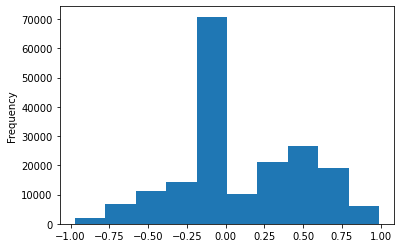

In [ ]:
%matplotlib inline


t3_vader['vader_compound'].plot(kind='hist')

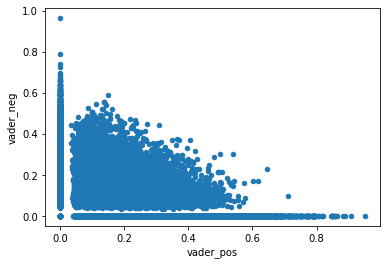

In [ ]:
t3_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t3_vader[sentiment_variables].mean()

vader_neg         0.051409
vader_neu         0.845168
vader_pos         0.103422
vader_compound    0.119800
dtype: float64

In [ ]:
t3_stats = sentiment_stats(t3_vader)

Count of positive Tweets:70167
Percent of positive Tweets:37.41501677002405
Average positive Tweet Score:0.5269988897914974

Count of neutral Tweets:88689
Percent of neutral Tweets:47.29146781701744
Average neutral Tweet Score:-0.002924714451623087

Count of negative Tweets:28681
Percent of negative Tweets:15.293515412958508
Average negative Tweet Score:-0.4969022349290471


,date,Twitter ID
0,2011-10-06,1723
1,2011-10-07,2067
2,2011-10-08,2142
3,2011-10-09,1785
4,2011-10-10,2173
...,...,...
131,2012-02-14,303
132,2012-02-15,278
133,2012-02-16,380
134,2012-02-17,346


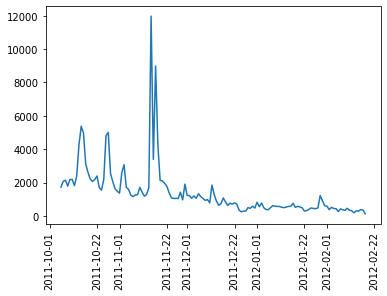

In [ ]:
tweets_per_day_calc(topic3)

Top Words


,Common_words,count
1,oakland,18378
2,occupy,9616
3,today,8593
4,#oo,7649
5,news,7565
6,#nycga,7243
7,time,6641
8,day,6615
9,tonight,6541
10,march,6147


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,oakland,5918
2,support,3731
3,occupy,3532
4,today,3474
5,please,3361
6,#solidarity,2983
7,us,2953
8,solidarity,2906
9,#nycga,2847
10,tonight,2788


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,oakland,8770
2,occupy,4779
3,today,3831
4,#oo,3830
5,#nycga,3479
6,news,3294
7,time,3136
8,day,2953
9,la,2932
10,tonight,2884


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,oakland,3690
2,news,1944
3,night,1324
4,occupy,1305
5,protest,1290
6,today,1288
7,#oo,1288
8,last,1226
9,police,1219
10,eviction,1166


-----------------------------------------------------------------


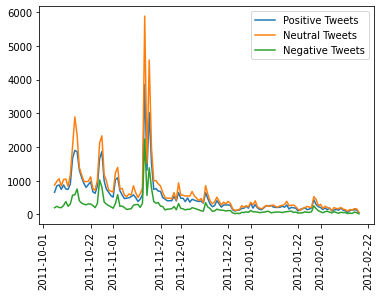

In [ ]:
commonWordsPerSentiment(t3_vader)

# Topic 4

In [ ]:
t4_vader = full_vader[full_vader['Topic'] == 4]

NameError: ignored

In [ ]:
topic4 = ows[ows['Topic']==4].reset_index()
topic4.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,1,4,121813163778899968,#ows White shirt= Brown shirt.,2011-10-06,2011-10-06 05:04:56,#ows white shirt brown shirt,"['#ows', 'white', 'shirt', 'brown', 'shirt']","['white', 'shirt', 'brown', 'shirt']",False,False,4,4,2011-10-06
1,4,23,121813284704882688,@LibertyBelle4 LOL! Its sneaking up on a lot o...,2011-10-06,2011-10-06 05:05:24,lol its sneaking up on lot of people but ...,"['lol', 'its', 'sneaking', 'up', 'on', 'lot', ...","['lol', 'sneaking', 'lot', 'sure', 'undivided'...",False,False,4,4,2011-10-06
2,11,65,121813602079490048,This is looking more and more like the Civil R...,2011-10-06,2011-10-06 05:06:40,this is looking more and more like the civil r...,"['this', 'is', 'looking', 'more', 'and', 'more...","['looking', 'civil', 'right', 'movement', 'bla...",False,False,4,4,2011-10-06
3,14,75,121813643821199360,#Anonymous Tows the Obama admin's line about e...,2011-10-06,2011-10-06 05:06:50,#anonymous tows the obama admin line about eco...,"['#anonymous', 'tows', 'the', 'obama', 'admin'...","['#anonymous', 'tows', 'obama', 'admin', 'line...",False,False,4,4,2011-10-06
4,30,129,121813843897888768,&quot;@Titleixbaby: #occupywallstreet Today th...,2011-10-06,2011-10-06 05:07:38,#occupywallstreet today the nypd maced fox ne...,"['#occupywallstreet', 'today', 'the', 'nypd', ...","['today', 'nypd', 'maced', 'fox', 'news', 'sto...",False,False,4,4,2011-10-06


In [ ]:
topic4.shape

(266432, 13)

In [ ]:
t4_vader = vaderize(topic4, 'clean_text')

Estimating polarity scores for 266432 cases.


In [ ]:
t4_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,1,1,4,4,121813163778899968,#ows White shirt= Brown shirt.,#ows white shirt brown shirt,"['#ows', 'white', 'shirt', 'brown', 'shirt']","['white', 'shirt', 'brown', 'shirt']",False,False,4,4,0.000,1.000,0.000,0.0000
1,4,4,23,23,121813284704882688,@LibertyBelle4 LOL! Its sneaking up on a lot o...,lol its sneaking up on lot of people but ...,"['lol', 'its', 'sneaking', 'up', 'on', 'lot', ...","['lol', 'sneaking', 'lot', 'sure', 'undivided'...",False,False,4,4,0.000,0.694,0.306,0.7579
2,11,11,65,65,121813602079490048,This is looking more and more like the Civil R...,this is looking more and more like the civil r...,"['this', 'is', 'looking', 'more', 'and', 'more...","['looking', 'civil', 'right', 'movement', 'bla...",False,False,4,4,0.000,0.891,0.109,0.4690
3,14,14,75,75,121813643821199360,#Anonymous Tows the Obama admin's line about e...,#anonymous tows the obama admin line about eco...,"['#anonymous', 'tows', 'the', 'obama', 'admin'...","['#anonymous', 'tows', 'obama', 'admin', 'line...",False,False,4,4,0.386,0.547,0.067,-0.8885
4,30,30,129,129,121813843897888768,&quot;@Titleixbaby: #occupywallstreet Today th...,#occupywallstreet today the nypd maced fox ne...,"['#occupywallstreet', 'today', 'the', 'nypd', ...","['today', 'nypd', 'maced', 'fox', 'news', 'sto...",False,False,4,4,0.143,0.649,0.208,0.2500


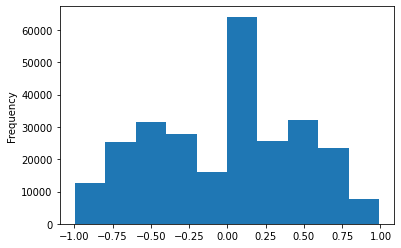

In [ ]:
%matplotlib inline


t4_vader['vader_compound'].plot(kind='hist')

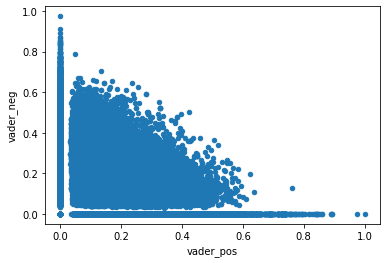

In [ ]:
t4_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t4_vader[sentiment_variables].mean()

vader_neg         0.113627
vader_neu         0.780891
vader_pos         0.105479
vader_compound   -0.027456
dtype: float64

In [ ]:
t4_stats = sentiment_stats(t4_vader)

Count of positive Tweets:81957
Percent of positive Tweets:30.76094463127552
Average positive Tweet Score:0.5360076637749064

Count of neutral Tweets:95319
Percent of neutral Tweets:35.776107975018014
Average neutral Tweet Score:-0.003318548243267345

Count of negative Tweets:89156
Percent of negative Tweets:33.46294739370646
Average negative Tweet Score:-0.5712283177800709


,date,Twitter ID
0,2011-10-06,2938
1,2011-10-07,4053
2,2011-10-08,3410
3,2011-10-09,3912
4,2011-10-10,5034
...,...,...
131,2012-02-14,428
132,2012-02-15,421
133,2012-02-16,602
134,2012-02-17,411


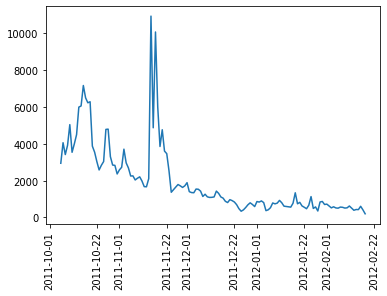

In [ ]:
tweets_per_day_calc(topic4)

Top Words


,Common_words,count
1,street,20333
2,wall,19340
3,movement,15968
4,obama,15475
5,party,15011
6,occupy,13601
7,would,12287
8,right,12167
9,think,12042
10,know,10987


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,party,9732
2,support,6792
3,street,6009
4,wall,5899
5,movement,5421
6,would,4978
7,occupy,4622
8,obama,4582
9,tea,4397
10,think,3881


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,street,8696
2,wall,7938
3,movement,5833
4,occupy,5622
5,obama,5338
6,think,4389
7,right,4323
8,know,4133
9,would,3947
10,#teaparty,3798


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,street,5628
2,obama,5555
3,wall,5503
4,movement,4714
5,right,4300
6,anti,3819
7,think,3772
8,#teaparty,3725
9,protest,3423
10,know,3375


-----------------------------------------------------------------


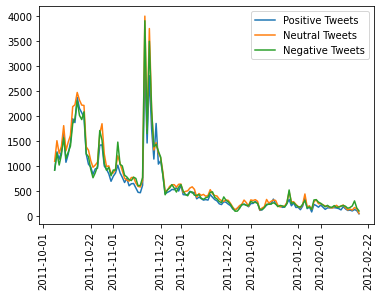

In [ ]:
commonWordsPerSentiment(t4_vader)

# Topic 5

In [ ]:
t5_vader = full_vader[full_vader['Topic'] == 5]

In [ ]:
topic5 = ows[ows['Topic']==5].reset_index()
topic5.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,2,13,121813232523558912,@AnonyOps @danielhewitt Wow. Self-defense is ...,2011-10-06,2011-10-06 05:05:12,wow self defense is obviously needed to prot...,"['wow', 'self', 'defense', 'is', 'obviously', ...","['wow', 'self', 'defense', 'obviously', 'neede...",False,False,5,5,2011-10-06
1,10,59,121813555510132738,I hope Wall Street is footing the bill for the...,2011-10-06,2011-10-06 05:06:29,i hope wall street is footing the bill for the...,"['i', 'hope', 'wall', 'street', 'is', 'footing...","['hope', 'wall', 'street', 'footing', 'bill', ...",False,False,5,5,2011-10-06
2,13,73,121813634870558720,@JeffSharlet ; was that the Fox crew that got ...,2011-10-06,2011-10-06 05:06:48,was that the fox crew that got kicked around ...,"['was', 'that', 'the', 'fox', 'crew', 'that', ...","['fox', 'crew', 'got', 'kicked', 'around', 'no...",False,False,5,5,2011-10-06
3,15,76,121813645012369408,"@joebelginhopper it's already started, i was a...",2011-10-06,2011-10-06 05:06:50,it already started was about seconds away f...,"['it', 'already', 'started', 'was', 'about', '...","['already', 'started', 'second', 'away', 'ting...",False,False,5,5,2011-10-06
4,18,86,121813686422732800,finally! tks god @pixls rumors police are goin...,2011-10-06,2011-10-06 05:07:00,finally tks god rumors police are going to gi...,"['finally', 'tks', 'god', 'rumor', 'police', '...","['finally', 'tks', 'god', 'rumor', 'police', '...",False,False,5,5,2011-10-06


In [ ]:
topic5.shape

(177784, 13)

In [ ]:
t5_vader = vaderize(topic5, 'clean_text')

Estimating polarity scores for 177784 cases.


In [ ]:
t5_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,2,2,13,13,121813232523558912,@AnonyOps @danielhewitt Wow. Self-defense is ...,wow self defense is obviously needed to prot...,"['wow', 'self', 'defense', 'is', 'obviously', ...","['wow', 'self', 'defense', 'obviously', 'neede...",False,False,5,5,0.142,0.562,0.296,0.6249
1,10,10,59,59,121813555510132738,I hope Wall Street is footing the bill for the...,i hope wall street is footing the bill for the...,"['i', 'hope', 'wall', 'street', 'is', 'footing...","['hope', 'wall', 'street', 'footing', 'bill', ...",False,False,5,5,0.114,0.684,0.202,0.3182
2,13,13,73,73,121813634870558720,@JeffSharlet ; was that the Fox crew that got ...,was that the fox crew that got kicked around ...,"['was', 'that', 'the', 'fox', 'crew', 'that', ...","['fox', 'crew', 'got', 'kicked', 'around', 'no...",False,False,5,5,0.000,1.000,0.000,0.0000
3,15,15,76,76,121813645012369408,"@joebelginhopper it's already started, i was a...",it already started was about seconds away f...,"['it', 'already', 'started', 'was', 'about', '...","['already', 'started', 'second', 'away', 'ting...",False,False,5,5,0.171,0.829,0.000,-0.4767
4,18,18,86,86,121813686422732800,finally! tks god @pixls rumors police are goin...,finally tks god rumors police are going to gi...,"['finally', 'tks', 'god', 'rumor', 'police', '...","['finally', 'tks', 'god', 'rumor', 'police', '...",False,False,5,5,0.176,0.738,0.086,-0.2960


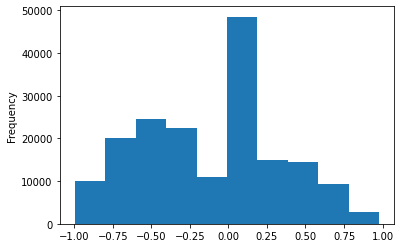

In [ ]:
%matplotlib inline


t5_vader['vader_compound'].plot(kind='hist')

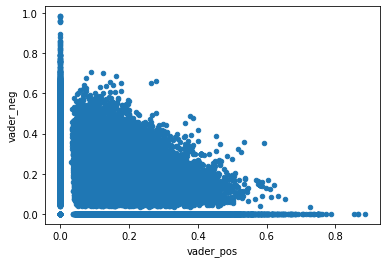

In [ ]:
t5_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t5_vader[sentiment_variables].mean()

vader_neg         0.130294
vader_neu         0.791901
vader_pos         0.077804
vader_compound   -0.125077
dtype: float64

In [ ]:
t5_stats = sentiment_stats(t5_vader)

Count of positive Tweets:37558
Percent of positive Tweets:21.125635602753903
Average positive Tweet Score:0.5069821023483679

Count of neutral Tweets:70819
Percent of neutral Tweets:39.834293299734505
Average neutral Tweet Score:-0.01812518250751917

Count of negative Tweets:69407
Percent of negative Tweets:39.040071097511586
Average negative Tweet Score:-0.5762283170285419


,date,Twitter ID
0,2011-10-06,986
1,2011-10-07,872
2,2011-10-08,1116
3,2011-10-09,1000
4,2011-10-10,1098
...,...,...
131,2012-02-14,116
132,2012-02-15,119
133,2012-02-16,147
134,2012-02-17,112


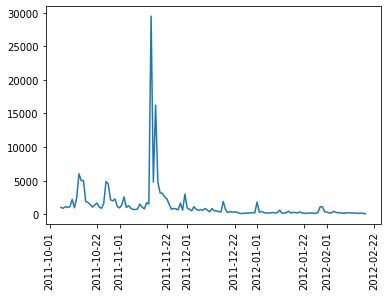

In [ ]:
tweets_per_day_calc(topic5)

Top Words


,Common_words,count
1,police,30405
2,park,20046
3,protester,17821
4,right,11121
5,cops,9811
6,protest,8954
7,nypd,8884
8,arrest,8418
9,oakland,8096
10,arrested,7416


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,police,5424
2,park,4995
3,peaceful,3297
4,right,2845
5,protester,2635
6,nypd,1951
7,cops,1883
8,city,1679
9,protest,1518
10,zuccotti,1482


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,police,9991
2,park,9425
3,protester,6483
4,right,4005
5,cops,3478
6,nypd,3263
7,zuccotti,3213
8,protest,3098
9,street,2976
10,city,2808


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,police,14990
2,protester,8703
3,arrest,6495
4,arrested,6050
5,park,5626
6,cops,4450
7,protest,4338
8,right,4271
9,violence,4259
10,oakland,3890


-----------------------------------------------------------------


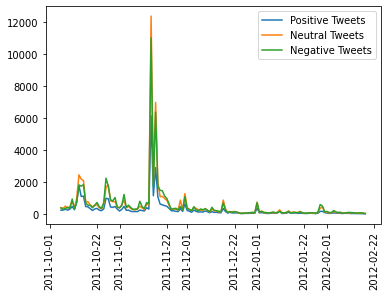

In [ ]:
commonWordsPerSentiment(t5_vader)

# Topic 6

In [ ]:
t6_vader = full_vader[full_vader['Topic'] == 6]

In [ ]:
topic6 = ows[ows['Topic']==6].reset_index()
topic6.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,0,2,121813150000619521,@Seductivpancake Right! Those guys have a vict...,2011-10-06,2011-10-06 05:04:52,right those guys have victory condition re...,"['right', 'those', 'guys', 'have', 'victory', ...","['right', 'guys', 'victory', 'condition', 'reg...",False,False,6,9,2011-10-06
1,8,33,121813337586675712,"Generation iPod vs. Corpocracy? I know, it's c...",2011-10-06,2011-10-06 05:05:37,generation ipod vs corpocracy know it confu...,"['generation', 'ipod', 'vs', 'corpocracy', 'kn...","['generation', 'ipod', 'vs', 'corpocracy', 'kn...",False,False,6,9,2011-10-06
2,21,96,121813740059496448,People are waking up to the fact that it isn't...,2011-10-06,2011-10-06 05:07:13,people are waking up to the fact that it isn ...,"['people', 'are', 'waking', 'up', 'to', 'the',...","['waking', 'fact', 'government', 'oppressing',...",False,False,6,9,2011-10-06
3,24,101,121813754412412928,@SabzBrach #ows I disagree. Please DO dox Lt. ...,2011-10-06,2011-10-06 05:07:16,#ows disagree please do dox lt connely he...,"['#ows', 'disagree', 'please', 'do', 'dox', 'l...","['disagree', 'please', 'dox', 'lt', 'connely',...",False,False,6,9,2011-10-06
4,25,109,121813772682801152,@greg_rakozy you're right. which is exactly wh...,2011-10-06,2011-10-06 05:07:21,you re right which is exactly what #ows is ...,"['you', 're', 'right', 'which', 'is', 'exactly...","['right', 'exactly', 'big', 'business', 'takin...",False,False,6,9,2011-10-06


In [ ]:
topic6.shape

(222949, 13)

In [ ]:
t6_vader = vaderize(topic6, 'clean_text')

Estimating polarity scores for 222949 cases.


In [ ]:
t6_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,0,0,2,2,121813150000619521,@Seductivpancake Right! Those guys have a vict...,right those guys have victory condition re...,"['right', 'those', 'guys', 'have', 'victory', ...","['right', 'guys', 'victory', 'condition', 'reg...",False,False,6,9,0.000,1.000,0.000,0.0000
1,8,8,33,33,121813337586675712,"Generation iPod vs. Corpocracy? I know, it's c...",generation ipod vs corpocracy know it confu...,"['generation', 'ipod', 'vs', 'corpocracy', 'kn...","['generation', 'ipod', 'vs', 'corpocracy', 'kn...",False,False,6,9,0.116,0.884,0.000,-0.1154
2,21,21,96,96,121813740059496448,People are waking up to the fact that it isn't...,people are waking up to the fact that it isn ...,"['people', 'are', 'waking', 'up', 'to', 'the',...","['waking', 'fact', 'government', 'oppressing',...",False,False,6,9,0.000,1.000,0.000,0.0000
3,24,24,101,101,121813754412412928,@SabzBrach #ows I disagree. Please DO dox Lt. ...,#ows disagree please do dox lt connely he...,"['#ows', 'disagree', 'please', 'do', 'dox', 'l...","['disagree', 'please', 'dox', 'lt', 'connely',...",False,False,6,9,0.231,0.682,0.087,-0.5859
4,25,25,109,109,121813772682801152,@greg_rakozy you're right. which is exactly wh...,you re right which is exactly what #ows is ...,"['you', 're', 'right', 'which', 'is', 'exactly...","['right', 'exactly', 'big', 'business', 'takin...",False,False,6,9,0.057,0.943,0.000,-0.1027


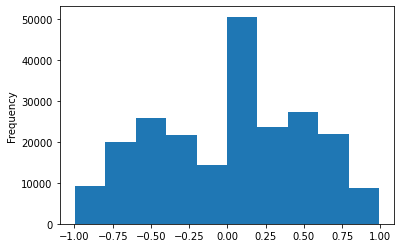

In [ ]:
%matplotlib inline


t6_vader['vader_compound'].plot(kind='hist')

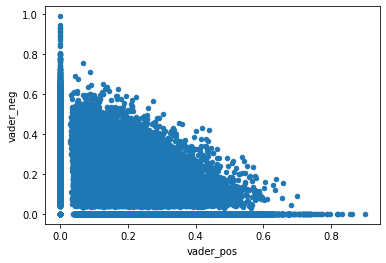

In [ ]:
t6_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t6_vader[sentiment_variables].mean()

vader_neg         0.109525
vader_neu         0.775662
vader_pos         0.114812
vader_compound    0.008900
dtype: float64

In [ ]:
t6_stats = sentiment_stats(t6_vader)

Count of positive Tweets:75737
Percent of positive Tweets:33.970549318454
Average positive Tweet Score:0.5516132141489628

Count of neutral Tweets:76784
Percent of neutral Tweets:34.44016344545165
Average neutral Tweet Score:-0.0006148273077724528

Count of negative Tweets:70428
Percent of negative Tweets:31.589287236094354
Average negative Tweet Score:-0.5643496649060034


,date,Twitter ID
0,2011-10-06,2158
1,2011-10-07,3108
2,2011-10-08,2897
3,2011-10-09,3331
4,2011-10-10,3702
...,...,...
131,2012-02-14,461
132,2012-02-15,502
133,2012-02-16,469
134,2012-02-17,384


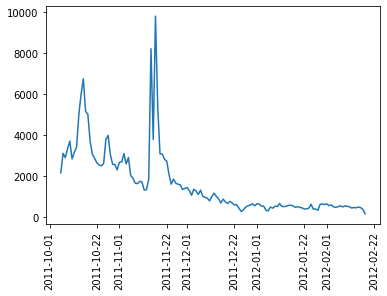

In [ ]:
tweets_per_day_calc(topic6)

Top Words


,Common_words,count
1,want,15505
2,1%,12666
3,99%,11770
4,money,11072
5,bank,11042
6,make,11001
7,need,10494
8,us,10353
9,work,10243
10,right,9481


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,want,5912
2,1%,4258
3,make,4063
4,99%,4003
5,free,3930
6,money,3923
7,bank,3899
8,need,3786
9,rich,3783
10,work,3744


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,want,5794
2,1%,4713
3,99%,4558
4,money,4028
5,need,3841
6,work,3816
7,make,3723
8,bank,3599
9,us,3376
10,change,3217


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,want,3799
2,1%,3695
3,bank,3544
4,us,3316
5,problem,3285
6,make,3215
7,right,3214
8,99%,3209
9,money,3121
10,one,3032


-----------------------------------------------------------------


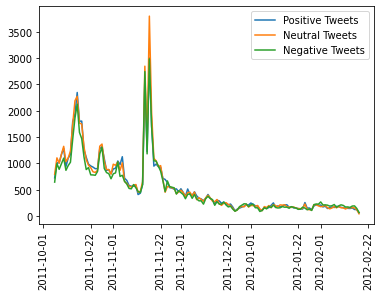

In [ ]:
commonWordsPerSentiment(t6_vader)

# Topic 7

In [ ]:
t7_vader = full_vader[full_vader['Topic'] == 7]

In [ ]:
topic7 = ows[ows['Topic']==7].reset_index()
topic7.head()

,index,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
0,3,14,121813245488140288,@HumanityCritic i'm worried that the #ows sell...,2011-10-06,2011-10-06 05:05:15,m worried that the #ows sells out to the ham...,"['m', 'worried', 'that', 'the', '#ows', 'sell'...","['worried', 'sell', 'hamsher', 'norquist', 'sp...",False,False,7,8,2011-10-06
1,6,28,121813306553020416,Artist captured the truth of the incestuous fl...,2011-10-06,2011-10-06 05:05:30,artist captured the truth of the incestuous fl...,"['artist', 'captured', 'the', 'truth', 'of', '...","['artist', 'captured', 'truth', 'incestuous', ...",False,False,7,8,2011-10-06
2,9,55,121813546924376066,“@ModernBetsy: My dad said &quot;You don't rem...,2011-10-06,2011-10-06 05:06:27,my dad said you don remember vietnam this is...,"['my', 'dad', 'said', 'you', 'don', 'remember'...","['dad', 'said', 'remember', 'vietnam', 'best',...",False,False,7,8,2011-10-06
3,12,70,121813625265590274,Pls RT We are mad as hell and we are not going...,2011-10-06,2011-10-06 05:06:46,pls rt we are mad as hell and we are not going...,"['pls', 'rt', 'we', 'are', 'mad', 'as', 'hell'...","['pls', 'rt', 'mad', 'hell', 'going', 'take', ...",False,False,7,8,2011-10-06
4,17,81,121813670148833280,#ows Keep your heads. #NYPD are not your enemi...,2011-10-06,2011-10-06 05:06:56,#ows keep your heads #nypd are not your enemi...,"['#ows', 'keep', 'your', 'head', '#nypd', 'are...","['keep', 'head', '#nypd', 'enemy', 'jobs', 'wa...",False,False,7,8,2011-10-06


In [ ]:
topic7.shape

(194445, 13)

In [ ]:
t7_vader = vaderize(topic7, 'clean_text')

Estimating polarity scores for 194445 cases.


In [ ]:
t4_vader.head()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Twitter ID,Text,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,vader_neg,vader_neu,vader_pos,vader_compound
0,1,1,4,4,121813163778899968,#ows White shirt= Brown shirt.,#ows white shirt brown shirt,"['#ows', 'white', 'shirt', 'brown', 'shirt']","['white', 'shirt', 'brown', 'shirt']",False,False,4,4,0.000,1.000,0.000,0.0000
1,4,4,23,23,121813284704882688,@LibertyBelle4 LOL! Its sneaking up on a lot o...,lol its sneaking up on lot of people but ...,"['lol', 'its', 'sneaking', 'up', 'on', 'lot', ...","['lol', 'sneaking', 'lot', 'sure', 'undivided'...",False,False,4,4,0.000,0.694,0.306,0.7579
2,11,11,65,65,121813602079490048,This is looking more and more like the Civil R...,this is looking more and more like the civil r...,"['this', 'is', 'looking', 'more', 'and', 'more...","['looking', 'civil', 'right', 'movement', 'bla...",False,False,4,4,0.000,0.891,0.109,0.4690
3,14,14,75,75,121813643821199360,#Anonymous Tows the Obama admin's line about e...,#anonymous tows the obama admin line about eco...,"['#anonymous', 'tows', 'the', 'obama', 'admin'...","['#anonymous', 'tows', 'obama', 'admin', 'line...",False,False,4,4,0.386,0.547,0.067,-0.8885
4,30,30,129,129,121813843897888768,&quot;@Titleixbaby: #occupywallstreet Today th...,#occupywallstreet today the nypd maced fox ne...,"['#occupywallstreet', 'today', 'the', 'nypd', ...","['today', 'nypd', 'maced', 'fox', 'news', 'sto...",False,False,4,4,0.143,0.649,0.208,0.2500


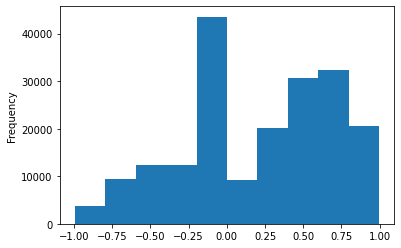

In [ ]:
%matplotlib inline


t7_vader['vader_compound'].plot(kind='hist')

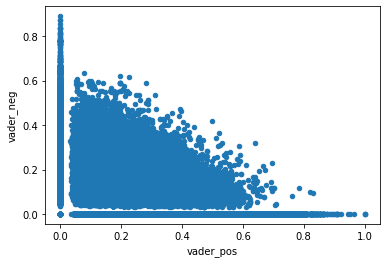

In [ ]:
t7_vader.plot.scatter(x='vader_pos', y = 'vader_neg')

In [ ]:
sentiment_variables = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

t7_vader[sentiment_variables].mean()

vader_neg         0.071835
vader_neu         0.754034
vader_pos         0.174128
vader_compound    0.216764
dtype: float64

In [ ]:
t7_stats = sentiment_stats(t7_vader)

Count of positive Tweets:99636
Percent of positive Tweets:51.24122502507136
Average positive Tweet Score:0.6073557981051025

Count of neutral Tweets:60778
Percent of neutral Tweets:31.257167836663324
Average neutral Tweet Score:0.002520632465694824

Count of negative Tweets:34031
Percent of negative Tweets:17.501607138265317
Average negative Tweet Score:-0.5441830801328201


,date,Twitter ID
0,2011-10-06,1701
1,2011-10-07,2272
2,2011-10-08,2089
3,2011-10-09,2111
4,2011-10-10,2457
...,...,...
131,2012-02-14,384
132,2012-02-15,321
133,2012-02-16,337
134,2012-02-17,334


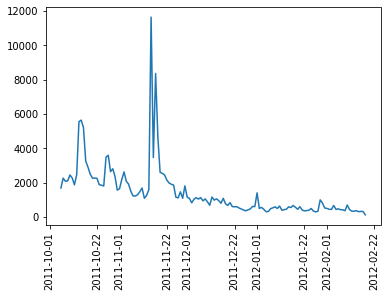

In [ ]:
tweets_per_day_calc(topic7)

Top Words


,Common_words,count
1,#oo,11868
2,us,10530
3,world,10113
4,go,8970
5,love,7945
6,back,7746
7,time,7378
8,stay,7037
9,day,7025
10,#solidarity,6950


-----------------------------------------------------------------
Top Positive Words


,Common_words,count
1,love,7291
2,#solidarity,5834
3,us,5506
4,good,5408
5,#oo,5208
6,world,5179
7,stay,5140
8,support,4620
9,strong,4177
10,keep,4073


-----------------------------------------------------------------
Top Neutral Words


,Common_words,count
1,#oo,4131
2,world,3402
3,go,3307
4,us,2936
5,back,2351
6,time,2311
7,toher,2248
8,need,2162
9,make,2089
10,day,2001


-----------------------------------------------------------------
Top Negative Words


,Common_words,count
1,#oo,2529
2,us,2088
3,fight,2075
4,go,2060
5,shit,1635
6,world,1532
7,time,1373
8,back,1364
9,day,1345
10,going,1306


-----------------------------------------------------------------


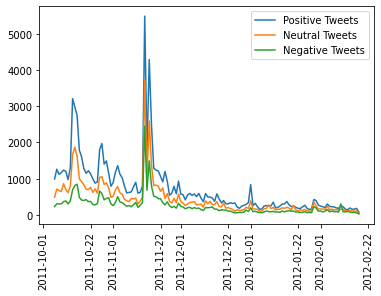

In [ ]:
commonWordsPerSentiment(t7_vader)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
full[full['Topic']==2].sample(1)['Text']

1116900    Forecast for NYC Thursday night: Mostly clear. Low temp: 42F.  #OWS #sgp #tlot
Name: Text, dtype: object

In [ ]:
rpTweets = t1_vader[t1_vader['clean_text'].str.contains('taxpayer')]

In [ ]:
rpTweets['Text'].sample(50)

452340                    I think it is a good idea we dont have the taxpayers bailing out eternally institutions that are bankrupt #RonPaul #OccupyWallstreet #OWS
10502                    #OWS and #ODC protesters aren't against capitalism so much as against corporate welfare Stop subsidizing corporations w taxpayer bailouts!
1065808                   I think it is a good idea that we don’t have the taxpayers bailing out eternally institutions that are bankrupt #TeaParty #OWS #ENDTHEFED
300463                  A Middle East dictator killed and it did NOT need Americans &amp; Iraqi deaths and TRILLIONS OF TAXPAYER DOLLARS to do it #tcot #Obama #OWS
171878                                      MT @toddstarnes: #OWS - why are elected officials siding with the lawbreakers instead of taxpayers and property owners?
375387                                 [FUN FACT] the FDIC &amp; taxpayers are on the hook for BofA derivatives +15x greater than TOTAL national student debt. #OWS
1033936         

In [ ]:
rpTweets.shape

(7464, 18)

In [ ]:
sentiment_stats(rpTweets)

Count of positive Tweets:2253
Percent of positive Tweets:32.062046392486124
Average positive Tweet Score:0.5383589436307147

Count of neutral Tweets:3339
Percent of neutral Tweets:47.51672121815853
Average neutral Tweet Score:0.0004125486672656485

Count of negative Tweets:1435
Percent of negative Tweets:20.421232389355342
Average negative Tweet Score:-0.4876860627177701


{'PosCount': 2253,
 'PosPerc': 32.062046392486124,
 'PosAvg': 0.5383589436307147,
 'NeuCount': 3339,
 'NeuPerc': 47.51672121815853,
 'NeuAvg': 0.0004125486672656485,
 'NegCount': 1435,
 'NegPerc': 20.421232389355342,
 'NegAvg': -0.4876860627177701}

,date,Twitter ID
0,2011-10-06,82
1,2011-10-07,103
2,2011-10-08,57
3,2011-10-09,67
4,2011-10-10,67
...,...,...
131,2012-02-14,3
132,2012-02-15,8
133,2012-02-16,8
134,2012-02-17,7


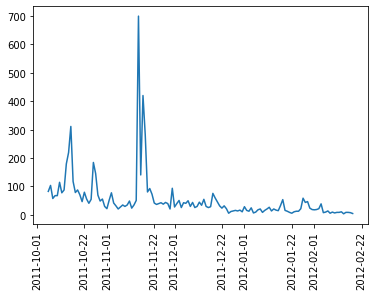

In [ ]:
tweets_per_day_calc(rpTweets)

In [ ]:
ows[ows['clean_text'].str.contains('marx')].sample(50)
#[t5_vader['vader_compound'] < -0.25]

,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
455714,19942214,131068989072879616,@anoki HAHAHAHA!!! Typical #Marxist criminal #OccupyWallStreet tactic. #OWS = criminals HAHAHAHA! #tcot,2011-10-31,2011-10-31 18:04:16,hahahaha typical #marxist criminal #occupywallstreet tactic #ows criminals hahahaha #tcot,"['hahahaha', 'typical', '#marxist', 'criminal', '#occupywallstreet', 'tactic', '#ows', 'criminal', 'hahahaha', '#tcot']","['hahahaha', 'typical', '#marxist', 'criminal', 'tactic', 'criminal', 'hahahaha', '']",False,False,4,4,2011-10-31
412992,18926455,129927615631982593,@mgsledge Y r u surprised that a Tahrir Sq. protester bought up Karl Marx in a speech to #OWS? Have u read Das Kapital or Communist Manif?,2011-10-28,2011-10-28 14:28:52,r surprised that tahrir sq protester bought up karl marx in speech to #ows have read das kapital or communist manif,"['r', 'surprised', 'that', 'tahrir', 'sq', 'protester', 'bought', 'up', 'karl', 'marx', 'in', 'speech', 'to', '#ows', 'have', 'read', 'das', 'kapital', 'or', 'communist', 'manif']","['r', 'surprised', 'tahrir', 'sq', 'protester', 'bought', 'karl', 'marx', 'speech', 'read', 'das', 'kapital', 'communist', 'manif']",False,False,4,4,2011-10-28
308064,15179120,127586110724513793,"So true&quot;@jjauthor: #Obama2012slogans: “#OWS may stand with Marxists, Communists &amp; Anarchists – but if they’ll vote for us, we’re with them!&quot;",2011-10-22,2011-10-22 03:24:33,so true #obama2012slogans #ows may stand with marxists communists anarchists but if they ll vote for us we re with them,"['so', 'true', '#obama2012slogans', '#ows', 'may', 'stand', 'with', 'marxist', 'communist', 'anarchist', 'but', 'if', 'they', 'll', 'vote', 'for', 'us', 'we', 're', 'with', 'them']","['true', '#obama2012slogans', 'may', 'stand', 'marxist', 'communist', 'anarchist', 'vote', 'us']",False,False,4,4,2011-10-22
695364,33849956,136695483124035584,100 million dead but you fail to make the connection... Marxism is for morons. #ows #occupyoakland #occupynyc #occupyportland #oo #occupysf,2011-11-16,2011-11-16 06:41:57,100 million dead but you fail to make the connection marxism is for morons #ows #occupyoakland #occupynyc #occupyportland #oo #occupysf,"['100', 'million', 'dead', 'but', 'you', 'fail', 'to', 'make', 'the', 'connection', 'marxism', 'is', 'for', 'moron', '#ows', '#occupyoakland', '#occupynyc', '#occupyportland', '#oo', '#occupysf']","['100', 'million', 'dead', 'fail', 'make', 'connection', 'marxism', 'moron', 'oakland', 'nyc', 'portland', '#oo', 'sf']",False,False,3,8,2011-11-16
632334,30083966,136369778641215488,Its interesting to see how many middle class white ppl #ows is radicalizing...randos from my high school are all of a sudden quoting marx?!,2011-11-15,2011-11-15 09:07:43,its interesting to see how many middle class white ppl #ows is radicalizing randos from my high school are all of sudden quoting marx,"['its', 'interesting', 'to', 'see', 'how', 'many', 'middle', 'class', 'white', 'ppl', '#ows', 'is', 'radicalizing', 'randos', 'from', 'my', 'high', 'school', 'are', 'all', 'of', 'sudden', 'quoting', 'marx']","['interesting', 'see', 'many', 'middle', 'class', 'white', 'ppl', 'radicalizing', 'randos', 'high', 'school', 'sudden', 'quoting', 'marx']",False,False,4,4,2011-11-15
1213428,75959696,165724559847329792,Our literary and art workers must gradually move their feet over through the process of studying Marxism and society #OWS #occupywallstreet,2012-02-04,2012-02-04 09:13:08,our literary and art workers must gradually move their feet over through the process of studying marxism and society #ows #occupywallstreet,"['our', 'literary', 'and', 'art', 'worker', 'must', 'gradually', 'move', 'their', 'feet', 'over', 'through', 'the', 'process', 'of', 'studying', 'marxism', 'and', 'society', '#ows', '#occupywallstreet']","['literary', 'art', 'worker', 'must', 'gradually', 'move', 'feet', 'process', 'studying', 'marxi

In [ ]:
anonTweets = t0_vader[t0_vader['clean_text'].str.contains('#anonymous')]

In [ ]:
anonTweets.shape

(4209, 18)

In [ ]:
sentiment_stats(anonTweets)

Count of positive Tweets:1626
Percent of positive Tweets:38.63150392017106
Average positive Tweet Score:0.609309901599016

Count of neutral Tweets:1208
Percent of neutral Tweets:28.700403896412453
Average neutral Tweet Score:0.01454445364238411

Count of negative Tweets:1375
Percent of negative Tweets:32.66809218341648
Average negative Tweet Score:-0.5498916363636365


{'PosCount': 1626,
 'PosPerc': 38.63150392017106,
 'PosAvg': 0.609309901599016,
 'NeuCount': 1208,
 'NeuPerc': 28.700403896412453,
 'NeuAvg': 0.01454445364238411,
 'NegCount': 1375,
 'NegPerc': 32.66809218341648,
 'NegAvg': -0.5498916363636365}

,date,Twitter ID
0,2011-10-06,3
1,2011-10-07,6
2,2011-10-08,2
3,2011-10-09,5
4,2011-10-10,4
...,...,...
131,2012-02-14,231
132,2012-02-15,173
133,2012-02-16,236
134,2012-02-17,229


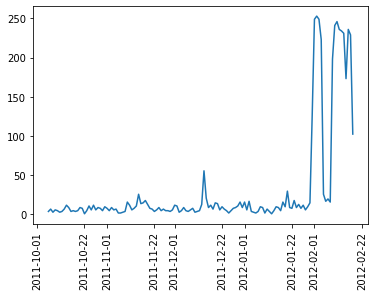

In [ ]:
tweets_per_day_calc(anonTweets)

In [ ]:
anonTweets[anonTweets['Text'].str.contains('war')]['Text'].sample(10)

1210192    @RonPaulsVoice #RonPaul can't end the wars because they're undeclared and this #Paulbot just said it. Pres has no real power #Anonymous #OWS
1250283                                 Since no one can define winning the war, just who do we expect to surrender? #RonPaul #OWS #TeaParty #Anonymous
1198981                     We can achieve more in peace than we ever can in these needless unconstitutional, undeclared wars. #RonPaul #OWS #Anonymous
1240309                                 Since no one can define winning the war, just who do we expect to surrender? #RonPaul #OWS #TeaParty #Anonymous
1233233            War is never economically beneficial except for those in position to profit from war expenditures #RonPaul #OWS #TeaParty #Anonymous
1243270                                 Since no one can define winning the war, just who do we expect to surrender? #RonPaul #OWS #TeaParty #Anonymous
1234093           We can achieve more in peace than we ever can in these needless uncons

In [ ]:
teapartyTweets = t0_vader[t0_vader['clean_text'].str.contains('#teaparty')]

In [ ]:
teapartyTweets.shape

(7952, 18)

In [ ]:
sentiment_stats(teapartyTweets)

Count of positive Tweets:3246
Percent of positive Tweets:40.81991951710261
Average positive Tweet Score:0.6118300369685767

Count of neutral Tweets:2209
Percent of neutral Tweets:27.779175050301813
Average neutral Tweet Score:0.0274143503847895

Count of negative Tweets:2497
Percent of negative Tweets:31.40090543259557
Average negative Tweet Score:-0.5620293952743293


{'PosCount': 3246,
 'PosPerc': 40.81991951710261,
 'PosAvg': 0.6118300369685767,
 'NeuCount': 2209,
 'NeuPerc': 27.779175050301813,
 'NeuAvg': 0.0274143503847895,
 'NegCount': 2497,
 'NegPerc': 31.40090543259557,
 'NegAvg': -0.5620293952743293}

,date,Twitter ID
0,2011-10-06,21
1,2011-10-07,36
2,2011-10-08,22
3,2011-10-09,25
4,2011-10-10,38
...,...,...
131,2012-02-14,268
132,2012-02-15,203
133,2012-02-16,277
134,2012-02-17,274


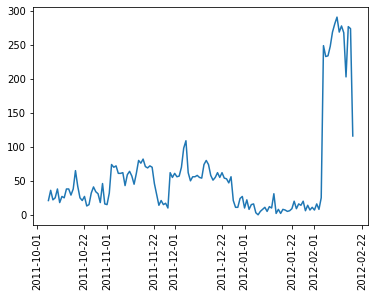

In [ ]:
tweets_per_day_calc(teapartyTweets)

In [ ]:
teapartyTweets['Text'].sample(10)

489468                                                                                                                                      2011-11-03
1246451             When we give any president - one man - too much power, we build a foundation for future tyranny #RonPaul #OWS #TeaParty #Anonymous
718738      #Occupy is a peaceful movement and If you don't believe us, we'll throw a Molotov Cocktail through your window. #tcot #tlot #ows #teaparty
1252226                                                                      Truth is treason in the empire of lies #RonPaul #OWS #TeaParty #Anonymous
1236333    The purpose of government is to protect the secrecy & the privacy of all individuals, not the secrecy of government #RonPaul #OWS #TeaParty
342828                                      @chuck_dizzle Gosh, how did the #TeaParty ever organize without living in parks? I just don't get it! #OWS
649434     We need 2 stop allowing secretive banking cartels to endlessly enslave us through m

In [ ]:
ronPaulTweets = t0_vader[t0_vader['clean_text'].str.contains('#ronpaul')]

In [ ]:
ronPaulTweets.shape

(12914, 18)

In [ ]:
sentiment_stats(ronPaulTweets)

Count of positive Tweets:5678
Percent of positive Tweets:43.96778689794022
Average positive Tweet Score:0.6128476047904192

Count of neutral Tweets:3444
Percent of neutral Tweets:26.668731609106395
Average neutral Tweet Score:0.03610606852497096

Count of negative Tweets:3792
Percent of negative Tweets:29.363481492953387
Average negative Tweet Score:-0.5563741033755274


{'PosCount': 5678,
 'PosPerc': 43.96778689794022,
 'PosAvg': 0.6128476047904192,
 'NeuCount': 3444,
 'NeuPerc': 26.668731609106395,
 'NeuAvg': 0.03610606852497096,
 'NegCount': 3792,
 'NegPerc': 29.363481492953387,
 'NegAvg': -0.5563741033755274}

,date,Twitter ID
0,2011-10-06,7
1,2011-10-07,17
2,2011-10-08,2
3,2011-10-09,7
4,2011-10-10,4
...,...,...
131,2012-02-14,351
132,2012-02-15,260
133,2012-02-16,356
134,2012-02-17,358


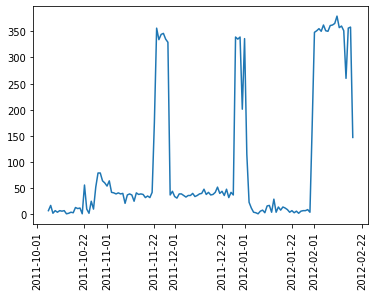

In [ ]:
tweets_per_day_calc(ronPaulTweets)

In [ ]:
ronPaulTweets['Text'].sample(10)

902540                                                  Right now your biggest threat comes from your own government #RonPaul #OWS #OccupyWallstreet
860850            The turbulent period we have entered may serve to remind Americans that the Fed cannot suspend the laws of economics #RonPaul #OWS
1219170          Governments that are supposed to be of the people & for the people routinely incur debts against the people #RonPaul #OWS #TeaParty
1080684    Despite what we hear from the cheerleaders in gov & in the media the economy remains in complete shambles #RonPaul #OWS #OccupyWallstreet
1202578                                                  All forms of authoritarianism only exist at the expense of liberty #RonPaul #OWS #Anonymous
1207548                                                        Right now your biggest threat comes from your own government #RonPaul #OWS #Anonymous
1199531         Governments that are supposed to be of the people & for the people routinely incur debts a

In [ ]:
full['Text'][214568]

'#ows should support and respect the police, they are subject to the same ponzi that has robbed everyone.  #endthefed #ronpaul #teaparty #ows'

In [ ]:
full['Text'][1132942]

'To dismiss the similar core values of the Occupiers, Tea Partiers, and Ron Paul Supporters would be unwise. #ows #occupy #ronpaul #teaparty'

In [ ]:
full[full['Text'].fillna('N/A').str.contains('#ronpaul #teaparty')].sample(20)

,Unnamed: 0,Twitter ID,Text,Day,Created At,clean_text,text_lemmatized,lemmatized_tokens,is_retweet,has_multimedia,Topic,Topic1,date
214568,11870437,125752893818159105,"#ows should support and respect the police, th...",2011-10-17,2011-10-17 02:00:00,#ows should support and respect the police th...,"['#ows', 'should', 'support', 'and', 'respect'...","['support', 'respect', 'police', 'subject', 'p...",False,False,1,9,2011-10-17
1055451,70498517,148983458830614528,R Republican candidates running for Prez of th...,2011-12-20,2011-12-20 04:29:59,r republican candidates running for prez of th...,"['r', 'republican', 'candidate', 'running', 'f...","['r', 'republican', 'candidate', 'running', 'p...",False,False,4,4,2011-12-20
464779,20645590,131397826415566848,I tend to find that most people are Ron Paul s...,2011-11-01,2011-11-01 15:50:57,i tend to find that most people are ron paul s...,"['i', 'tend', 'to', 'find', 'that', 'most', 'p...","['tend', 'find', 'ron', 'paul', 'supporter', '...",False,False,4,4,2011-11-01
544003,23555786,133701597384552449,@chucktodd a lot of us #ows WERE for the #ronp...,2011-11-08,2011-11-08 00:25:19,lot of us #ows were for the #ronpaul #teapar...,"['lot', 'of', 'us', '#ows', 'were', 'for', 'th...","['lot', 'us', '#ronpaul', '#teaparty', 'partia...",False,False,4,4,2011-11-08
948489,57967627,142669420454617088,Top Tags for #2012GOP: #QuestionsMittHates #p2...,2011-12-02,2011-12-02 18:20:15,top tags for #2012gop #questionsmitthates #p2...,"['top', 'tags', 'for', '#2012gop', '#questions...","['top', 'tags', '#2012gop', '#questionsmitthat...",False,False,4,4,2011-12-02
1114711,73289707,154810056301481984,"RT THIS: Set as your Facebook status, 'Google ...",2012-01-05,2012-01-05 06:22:48,rt this set as your facebook status google nd...,"['rt', 'this', 'set', 'as', 'your', 'facebook'...","['rt', 'set', 'facebook', 'status', 'google', ...",False,False,3,8,2012-01-05
544005,23555798,133701698802819072,@chucktodd a lot of us #ows were for the #ronp...,2011-11-08,2011-11-08 00:25:43,lot of us #ows were for the #ronpaul #teapar...,"['lot', 'of', 'us', '#ows', 'were', 'for', 'th...","['lot', 'us', '#ronpaul', '#teaparty', 'partia...",False,False,4,4,2011-11-08
1055543,70499010,148989602290614272,ALERT - RON PAUL WILL BE INTERVIEWED ON CNN TM...,2011-12-20,2011-12-20 04:54:23,alert ron paul will be interviewed on cnn tmrw...,"['alert', 'ron', 'paul', 'will', 'be', 'interv...","['alert', 'ron', 'paul', 'interviewed', 'cnn',...",False,False,3,8,2011-12-20
1132942,73487803,157019467736551426,To dismiss the similar core values of the Occu...,2012-01-11,2012-01-11 08:42:13,to dismiss the similar core values of the occu...,"['to', 'dismiss', 'the', 'similar', 'core', 'v...","['dismiss', 'similar', 'core', 'value', 'occup...",False,False,4,4,2012-01-11
58327,1378703,123338226462240768,Federal government spends $4 on every adult ov...,2011-10-10,2011-10-10 10:04:59,federal government spends on every adult over ...,"['federal', 'government', 'spends', 'on', 'eve...","['federal', 'government', 'spends', 'every', '...",False,False,1,9,2011-10-10


In [ ]:
full[full['Text'].fillna('N/A').str.contains('NYC authorities clearly')]['date'][614919]

Timestamp('2011-11-15 00:00:00')

In [ ]:
t0_vader['afinn_score'] = t0_vader['clean_text'].apply(afinn.score)
t0_vader['word_count'] = t0_vader['clean_text'].apply(word_count)
t0_vader['afinn_adjusted'] = t0_vader['afinn_score'] / t0_vader['word_count'] * 100


In [ ]:
t0_vader['afinn_adjusted'].describe()

count    54122.000000
mean        -0.499784
std         17.718359
min       -200.000000
25%         -8.333333
50%          0.000000
75%          6.666667
max        262.500000
Name: afinn_adjusted, dtype: float64